In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Set random seed
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# "Starter" hyperparameters
input_size = 28 * 28  # since MNIST images are 28x28 pixels
hidden_size = 128 # number of features in the hidden layer
num_classes = 10 # output classes (digits 0-9)
num_epochs = 5 # number of epochs to train the model
batch_size = 100 # number of samples per batch
learning_rate = 0.001 # learning rate for the optimizer

In [4]:
# A data preprocessing pipeline specifically for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load training data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Load test data
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Vanilla MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)
        # Fully connected layers with ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        # Output layer
        x = self.fc2(x)
        return x

In [6]:
# Initialize the model
model = MLP(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Lists to store training and test accuracies
train_losses = []
train_accuracies = []
test_accuracies = []

In [7]:
# Training loop
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')
    
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {epoch_acc:.2f}%, '
          f'Test Accuracy: {test_acc:.2f}%')

training_time = time.time() - start_time
print(f'Training completed in {training_time:.2f} seconds')

Epoch [1/5], Step [100/600], Loss: 0.4593
Epoch [1/5], Step [200/600], Loss: 0.4850
Epoch [1/5], Step [300/600], Loss: 0.2953
Epoch [1/5], Step [400/600], Loss: 0.1684
Epoch [1/5], Step [500/600], Loss: 0.1080
Epoch [1/5], Step [600/600], Loss: 0.0690
Epoch [1/5], Train Loss: 0.2858, Train Accuracy: 91.70%, Test Accuracy: 95.62%
Epoch [2/5], Step [100/600], Loss: 0.0938
Epoch [2/5], Step [200/600], Loss: 0.1257
Epoch [2/5], Step [300/600], Loss: 0.0847
Epoch [2/5], Step [400/600], Loss: 0.0811
Epoch [2/5], Step [500/600], Loss: 0.1794
Epoch [2/5], Step [600/600], Loss: 0.0449
Epoch [2/5], Train Loss: 0.1252, Train Accuracy: 96.31%, Test Accuracy: 96.75%
Epoch [3/5], Step [100/600], Loss: 0.0946
Epoch [3/5], Step [200/600], Loss: 0.0904
Epoch [3/5], Step [300/600], Loss: 0.0302
Epoch [3/5], Step [400/600], Loss: 0.0144
Epoch [3/5], Step [500/600], Loss: 0.0090
Epoch [3/5], Step [600/600], Loss: 0.0677
Epoch [3/5], Train Loss: 0.0864, Train Accuracy: 97.36%, Test Accuracy: 96.80%
Epoch [

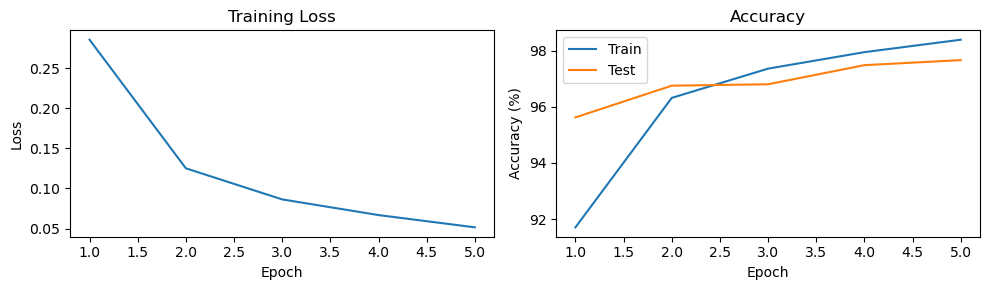

In [8]:
# Visualize training progress
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('mlp_training_progress.png')
plt.show()

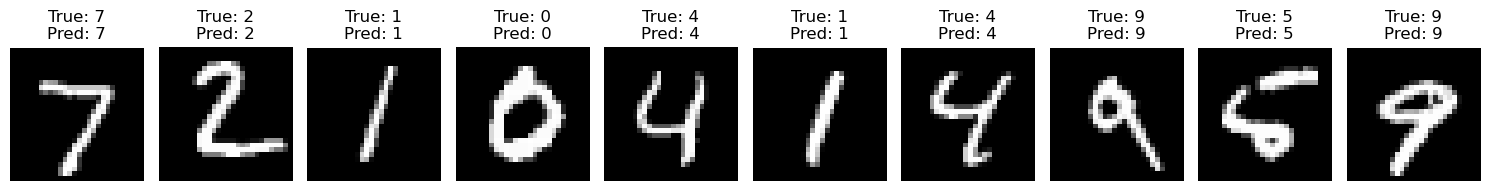

In [9]:
# Visualize some predictions
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f'True: {labels[i]}\nPred: {predicted[i].item()}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('mlp_predictions.png')
    plt.show()

visualize_predictions(model, test_loader)

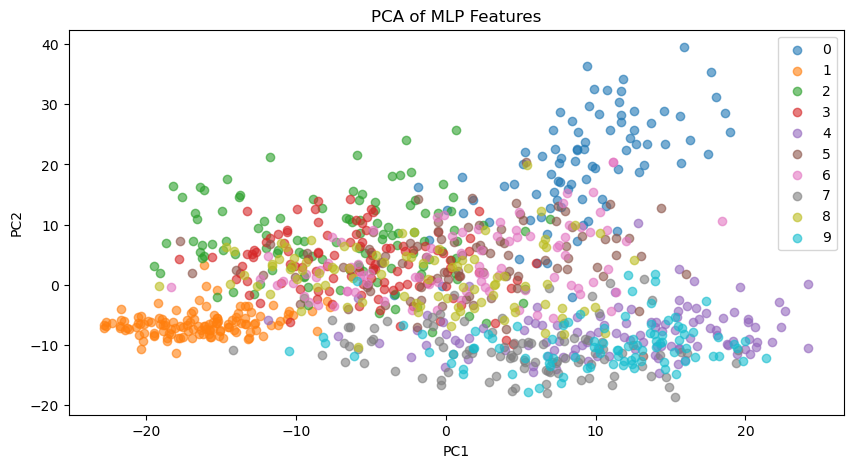

In [10]:
# Visualize what the model "sees" in the feature space
def visualize_feature_space(model, dataloader, num_samples=1000):
    model.eval()
    features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            if len(features) * batch_size >= num_samples:
                break
                
            images = images.to(device)
            
            # Get features from the first hidden layer
            flattened = model.flatten(images)
            layer1_features = model.relu(model.fc1(flattened))
            
            features.append(layer1_features.cpu().numpy())
            all_labels.append(labels.numpy())
    
    features = np.vstack(features)[:num_samples]
    all_labels = np.concatenate(all_labels)[:num_samples]
    
    # Use PCA to reduce to 2D for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 5))
    for i in range(10):  # 10 classes in MNIST
        plt.scatter(
            features_2d[all_labels == i, 0],
            features_2d[all_labels == i, 1],
            label=str(i),
            alpha=0.6
        )
    
    plt.legend()
    plt.title('PCA of MLP Features')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.savefig('mlp_feature_space.png')
    plt.show()

visualize_feature_space(model, test_loader)

In [11]:
# # Save the model
# torch.save(model.state_dict(), 'mlp_mnist.pt')
# print("Model saved to 'mlp_mnist.pt'")

In [16]:
import torch.onnx

dummy_input = torch.randn(1, 1, 28, 28, device='cuda:0')
torch.onnx.export(model, 
                  dummy_input, 
                  "model.onnx", 
                  input_names=["input"], 
                  output_names=["output"])

print("Model exported to model.onnx - now you can visualize it with Netron.app")

Model exported to model.onnx - now you can visualize it with Netron.app


In [19]:
import torchinfo
torchinfo.summary(model, input_size=(1, 1, 28, 28), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 128]                  100,480
├─ReLU: 1-3                              [1, 128]                  --
├─Linear: 1-4                            [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41